# Data Challenge: Smart meter is coming
by BCM Energy - Planète OUI

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import keras
from keras.layers import LSTM, Dense, Flatten, Dropout, Activation, SimpleRNN
from keras.models import Sequential

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import datetime

/home/leonardo/Documents/University/X/Courses/MAP541/AutoML/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/leonardo/Documents/University/X/Courses/MAP541/AutoML/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
X_train = pd.read_csv(
    'provided_data_and_metric/X_train_6GWGSxz.csv',
     index_col=0
)
Y_train = pd.read_csv(
    'provided_data_and_metric/y_train_2G60rOL.csv',
     index_col=0 
)
X_test = pd.read_csv(
    'provided_data_and_metric/X_test_c2uBt2s.csv', 
     index_col=0 
)

## Data Exploration

In [3]:
X_train.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,Unnamed: 9
time_step,,,,,,,,,
2013-03-17T00:01:00.0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-17T00:02:00.0,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-17T00:03:00.0,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-17T00:04:00.0,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-17T00:05:00.0,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
X_train.drop("Unnamed: 9", axis=1, inplace=True)
X_test.drop("Unnamed: 9", axis=1, inplace=True)

In [5]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(417599, 8)
(417599, 4)
(226081, 8)


**Analysing na**

In [6]:
Y_train.isna().sum()

washing_machine    10231
fridge_freezer     10231
TV                 10231
kettle             10231
dtype: int64

In [7]:
X_train.isna().sum()

consumption     10231
visibility     410663
temperature    410652
humidity       410663
humidex        410663
windchill      410671
wind           410663
pressure       410667
dtype: int64

Check if na values in global consumption reflect na values in the single appliances:

In [8]:
print((Y_train["washing_machine"].isna() == X_train["consumption"].isna()).sum())
print((Y_train["fridge_freezer"].isna() == X_train["consumption"].isna()).sum())
print((Y_train["TV"].isna() == X_train["consumption"].isna()).sum())
print((Y_train["kettle"].isna() == X_train["consumption"].isna()).sum())

417599
417599
417599
417599


For now, keep NAs, useful for RNN.

In [9]:
Y_train.isna().sum() / X_train.shape[0]

washing_machine    0.0245
fridge_freezer     0.0245
TV                 0.0245
kettle             0.0245
dtype: float64

### Dealing with NA

In [10]:
class DataImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        X = X.interpolate(method='linear').fillna(method='bfill')
        X.index = pd.to_datetime(X.index)
        return X

In [11]:
class YImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        X = X.interpolate(method='linear').fillna(method='bfill')
        X.index = pd.to_datetime(X.index)
        return X

In [12]:
di = DataImputer()
yi = YImputer()
x_trans = di.transform(X=X_train)
y_trans = yi.transform(X=Y_train)

Check that there are no more NaN after transformation:

In [13]:
x_trans.isna().sum()

consumption    0
visibility     0
temperature    0
humidity       0
humidex        0
windchill      0
wind           0
pressure       0
dtype: int64

## Prediction

In [14]:
X_train = X_train.append(X_train.iloc[-1, :])
Y_train = Y_train.append(Y_train.iloc[-1, :])

In [15]:
class RNNDataFormatter(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
#         print(X.shape)
        nb_col = X.shape[1]
#         print(nb_col)
        X_rnn = X[X.columns[:nb_col]]
        X_rnn = X_rnn.values.reshape((int(X_rnn.shape[0]/60), 60, nb_col))
        return X_rnn

In [16]:
p1 = Pipeline([
    (
        '1',
        DataImputer()
    ),
    (
        '2',
        RNNDataFormatter()
    )
])

In [17]:
p2 = Pipeline([
    (
        '1',
        YImputer()
    ),
    (
        '2',
        RNNDataFormatter()
    )
])

In [18]:
X = p1.transform(X_train)

In [19]:
Y = p2.transform(Y_train)

In [20]:
X.shape

(6960, 60, 8)

In [21]:
Y.shape

(6960, 60, 4)

In [22]:
X_train, y_train = X[:6000, :], Y[:6000, :, :]
X_valid, y_valid = X[6000:, :], Y[6000:, :, :]

**Baseline Model**

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 8]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(4, return_sequences=True)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 6000 samples, validate on 960 samples
Epoch 1/20
6000/6000 [==============================] - 5s 755us/step - loss: 4632.3739 - val_loss: 7174.6017
Epoch 2/20
6000/6000 [==============================] - 4s 622us/step - loss: 4624.2984 - val_loss: 7174.1343
Epoch 3/20
6000/6000 [==============================] - 4s 640us/step - loss: 4624.1037 - val_loss: 7174.0006
Epoch 4/20
6000/6000 [==============================] - 3s 562us/step - loss: 4624.0323 - val_loss: 7173.9489
Epoch 5/20
6000/6000 [==============================] - 3s 544us/step - loss: 4623.9975 - val_loss: 7173.9115
Epoch 6/20
6000/6000 [==============================] - 3s 532us/step - loss: 4623.9754 - val_loss: 7173.8733
Epoch 7/20
6000/6000 [==============================] - 3s 523us/step - loss: 4623.9637 - val_loss: 7173.8820
Epoch 8/20
6000/6000 [==============================] - 3s 524us/step - loss: 4623.9646 - val_loss: 7173.8794
Epoch 9/20
6000/6000 [==============================] - 3s 522us/step - l

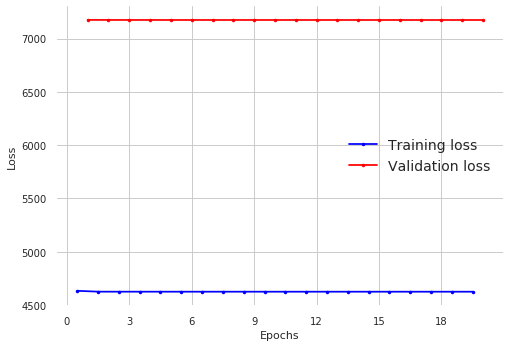

In [24]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
#     plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [25]:
model.predict(X_valid).shape

(960, 60, 4)